In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy

import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC

az.style.use("arviz-darkgrid")


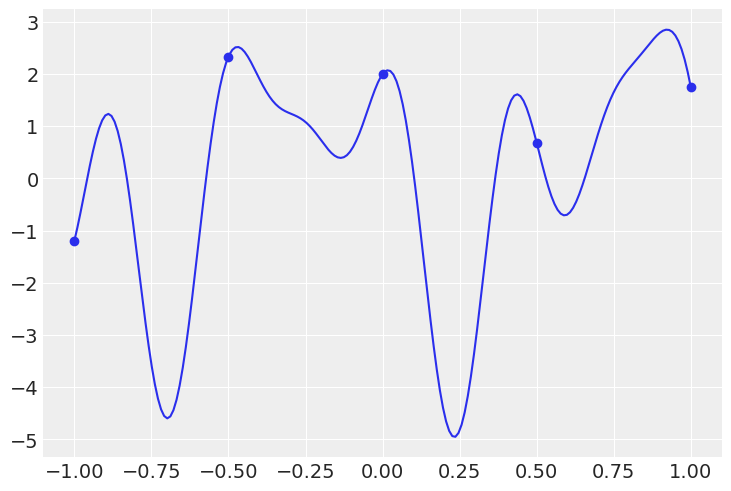

In [2]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

# data set
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
X_star = torch.linspace(-1, 1, 200)
y = f(X)
y_star = f(X_star)

plt.scatter(X, y)
plt.plot(X_star,y_star)

Warmup [1]:   0%|          | 0/125 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/125 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/125 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/125 [00:00, ?it/s]

c:\Users\Juliu\anaconda3\envs\OreL\lib\site-packages\arviz\data\io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.327  0.193     0.021      0.698      0.024    0.017   
kernel.variance     3.903  3.215     0.165      9.422      0.214    0.152   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale      66.0     145.0   1.05  
kernel.variance        166.0     102.0   1.01  


Warmup [1]:   0%|          | 0/225 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/225 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/225 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/225 [00:00, ?it/s]

c:\Users\Juliu\anaconda3\envs\OreL\lib\site-packages\arviz\data\io_pyro.py:153: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.295  0.166     0.014      0.580      0.026    0.019   
kernel.variance     4.465  5.132     0.845     12.434      0.560    0.397   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale      40.0     149.0   1.09  
kernel.variance        142.0     109.0   1.03  


array([<AxesSubplot:title={'center':'kernel.lengthscale'}>,
       <AxesSubplot:title={'center':'kernel.variance'}>], dtype=object)

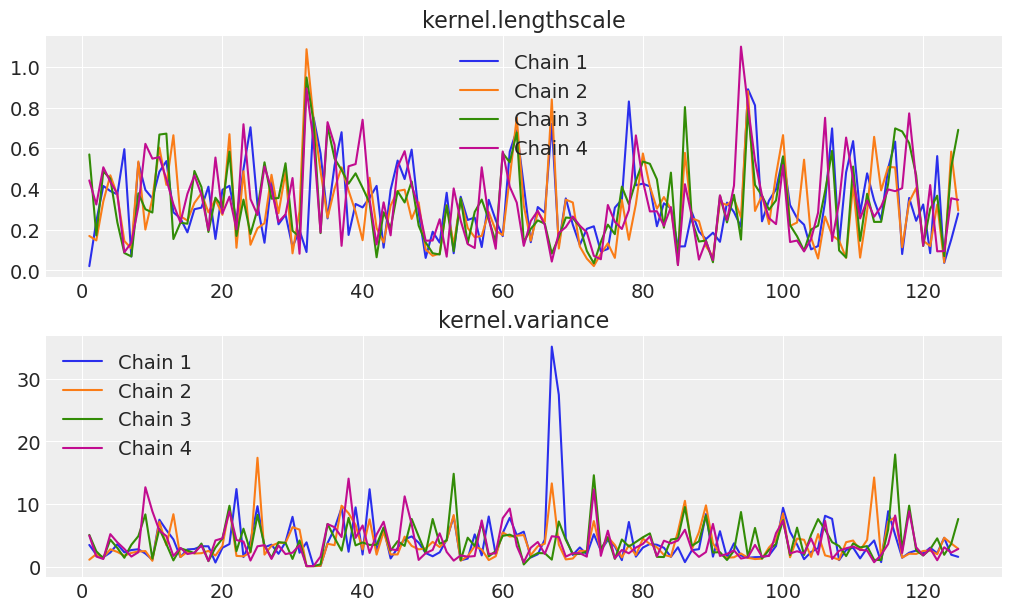

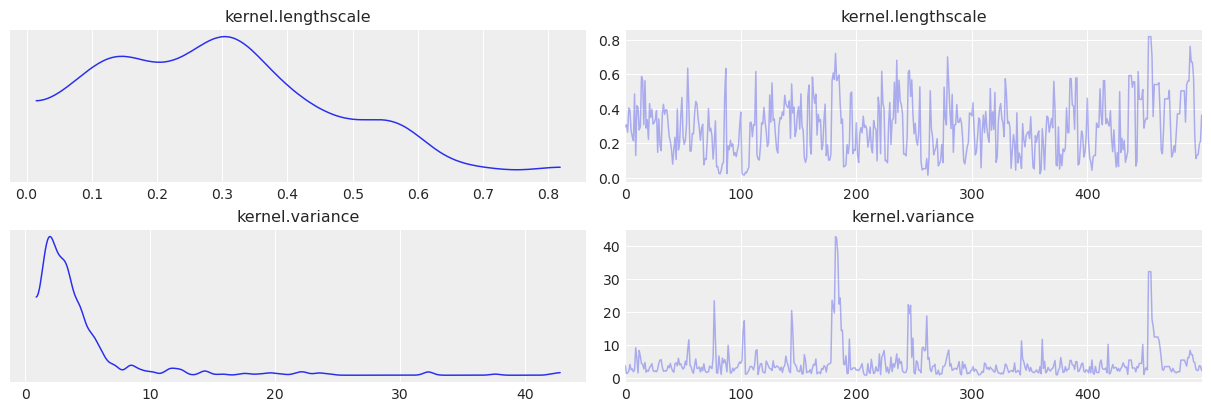

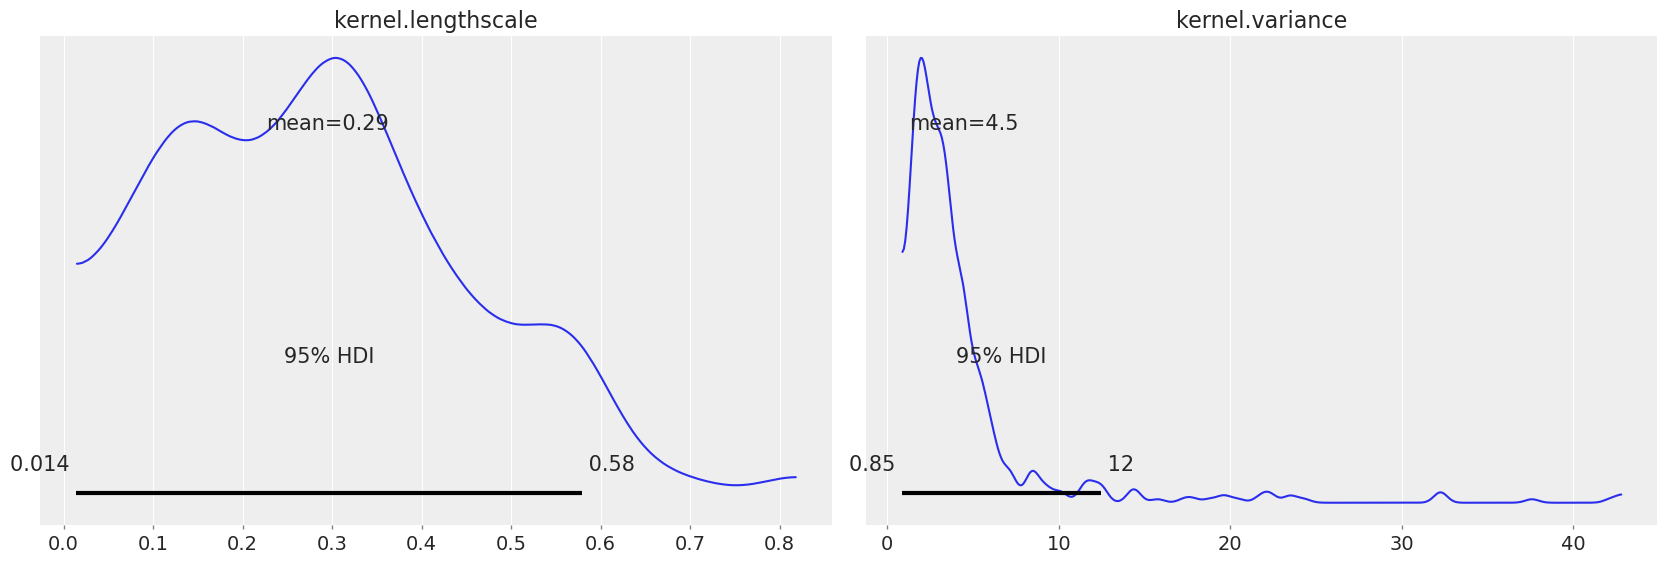

In [3]:
torch.manual_seed(2010)
pyro.clear_param_store()

# Assess convergence to stationary distribution using multiple chains
no_samples = 125
no_chains = 4

kernel = gp.kernels.RBF(input_dim=1)

kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=no_samples, num_chains=no_chains, warmup_steps=0)
mcmc.run()

posterior_ls_diagnostics = torch.reshape(mcmc.get_samples()["kernel.lengthscale"], (no_samples, no_chains))
posterior_var_diagnostics = torch.reshape(mcmc.get_samples()['kernel.variance'], (no_samples, no_chains))

fig, axs = plt.subplots(2, figsize=(10, 6))
for i in range(no_chains):
    axs[0].plot(np.arange(no_samples) + 1, posterior_ls_diagnostics[:, i], label=f'Chain {i + 1}')
    axs[0].set_title('kernel.lengthscale')
    axs[0].legend()
    axs[1].plot(np.arange(no_samples) + 1, posterior_var_diagnostics[:, i], label=f'Chain {i + 1}')
    axs[1].set_title('kernel.variance')
    axs[1].legend()

posterior_samples = az.from_pyro(mcmc)
summary = az.summary(posterior_samples, hdi_prob=0.95)
print(summary)

# Sample 500 draws from the posterior using sufficient warm-up period based on diagnostics
kernel = gp.kernels.RBF(input_dim=1)

kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=no_samples, num_chains=no_chains, warmup_steps=100)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

posterior_samples = az.from_pyro(mcmc)
summary = az.summary(posterior_samples, hdi_prob=0.95)
print(summary)

az.plot_trace(mcmc.get_samples(), compact=False)
az.plot_posterior(mcmc.get_samples(), hdi_prob=0.95)



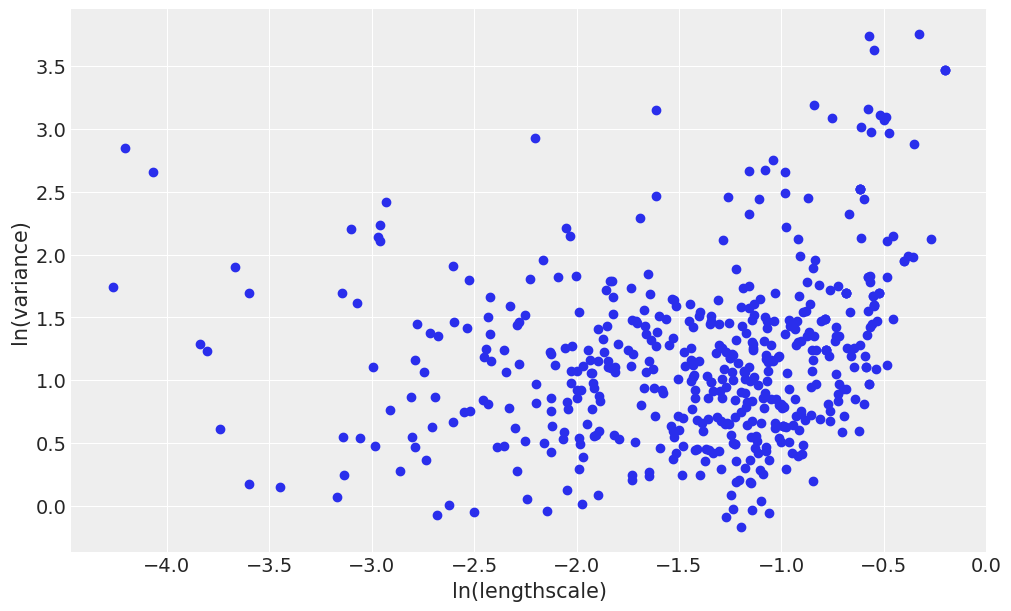

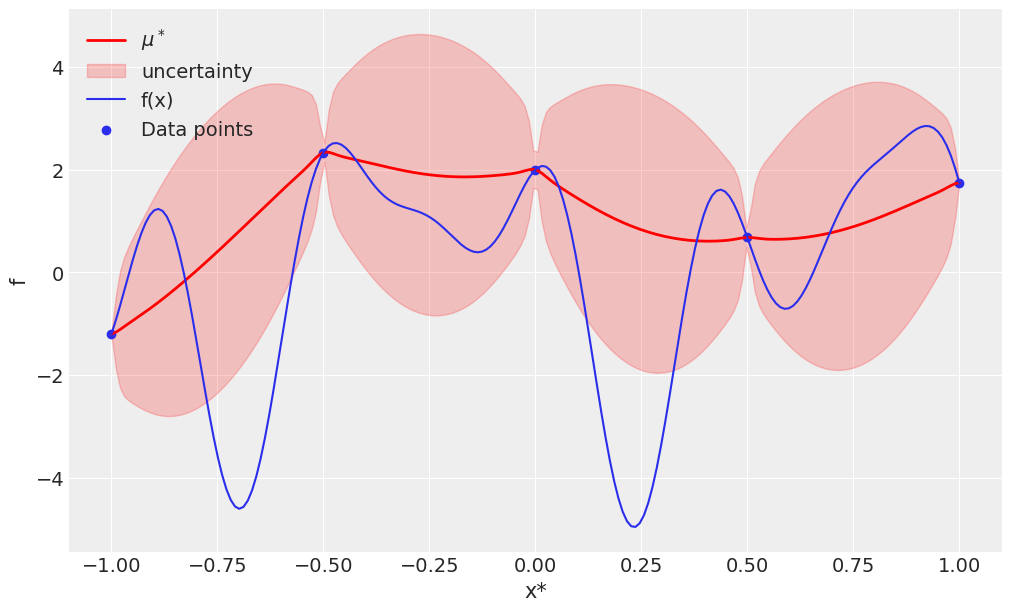

In [4]:
# Scatter plot on log-log scale of samples from posterior
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(torch.log(posterior_ls), torch.log(posterior_var))
plt.xlabel('ln(lengthscale)')
plt.ylabel('ln(variance)')

# Compute predictive mean and variance at x_stars
means = torch.zeros(len(X_star), no_samples)
covs  = torch.zeros(len(X_star), len(X_star), no_samples)

for i in range(no_samples):
    with torch.no_grad():
        gpr.kernel.lengthscale = posterior_ls[i]
        gpr.kernel.variance = posterior_var[i]
        means[:, i], covs[:, :, i] = gpr(X_star, full_cov=True, noiseless=False)

mean_post = means.mean(axis=1) # Posterior mean
cov_post = covs.mean(axis=2) # Posterior variance
sd = cov_post.diag().sqrt()  # standard deviation at each input point x

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(X_star.numpy(), mean_post.numpy(), "r", lw=2, label=r'$\mu^*$')  # plot the mean
ax.fill_between(
    X_star,  # plot the two-sigma uncertainty about the mean
    (mean_post - 2.0 * sd).numpy(),
    (mean_post + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
    label='uncertainty'
)
ax.plot(X_star, y_star, label='f(x)')
ax.scatter(X, y, label='Data points')
plt.xlabel('x*')
plt.ylabel('f')
plt.legend()

### Bayesian Optimization

Found minimums, 10 reps: tensor([-4.9492, -4.5962, -4.5962, -4.9492, -4.9492, -4.9492, -1.1983, -4.5962,
        -4.9492, -4.9492])
Number of iterations to find min: tensor([ 5.,  0.,  0., 18.,  7., 12.,  0.,  0., 10., 14.])


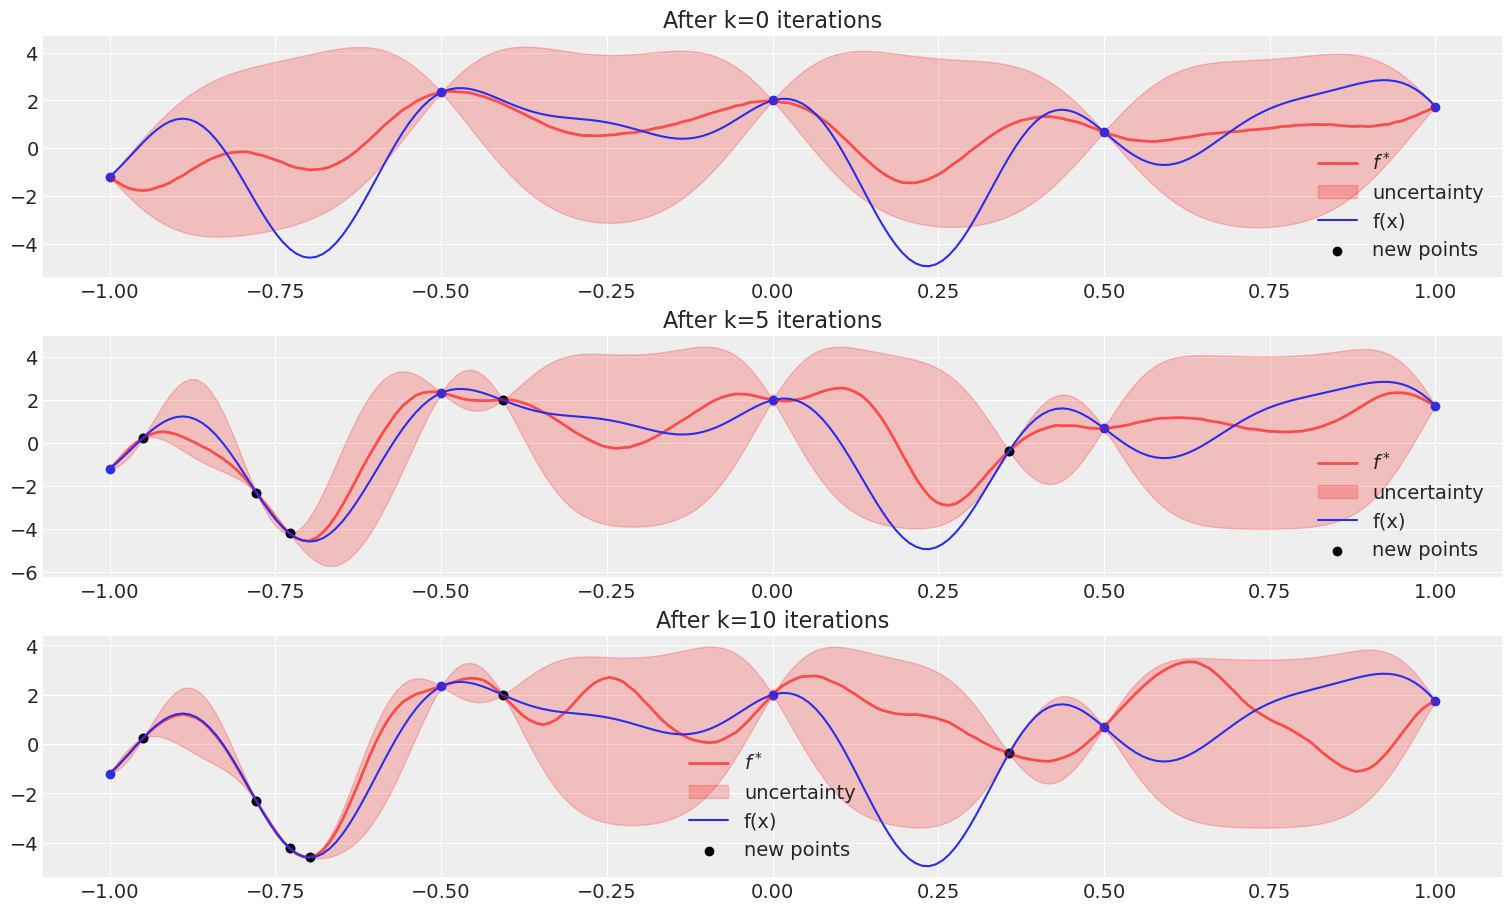

In [35]:
# Algorithm 1 - note we are supposed to plot f^*, and not mu^*
# torch.manual_seed(2005)
# torch.manual_seed(2010)
torch.manual_seed(2025)
T = 20
n_reps = 10 # Number of repetitions to repeat Baeysian optimization algorithm
ks = (0, 5, 10)

def Bayesian_optimization(X, y, X_star, y_star, T, naive=True, print=False):
    
    k = 0
    no_iter = 0
    if print == True:
        fig, axs = plt.subplots(3, 1, figsize=(15, 9))

    new_x_points = []
    new_y_points = []

    while k < T:

        pyro.clear_param_store()

        kernel = gp.kernels.RBF(input_dim=1)
        # kernel = gp.kernels.Matern32(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))
        nuts_kernel = NUTS(gpr.model)
        mcmc = MCMC(nuts_kernel, num_samples=1, disable_progbar=True, warmup_steps=10)
        try:
            mcmc.run()
        except: 
            mcmc.run()
        gpr.kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][0]
        gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][0]
        
        with torch.no_grad():
            mean, cov = gpr(X_star, full_cov=True, noiseless=False)

        # Draw from posterior
        try:
            f_star = torch.distributions.MultivariateNormal(mean, cov).sample()
        except ValueError: # if cov isn't positive definite, then resample
            continue

        if k in ks and print==True:
            sd = cov.diag().sqrt()  # standard deviation at each input point x
            axs[ks.index(k)].plot(X_star.numpy(), f_star, lw=2, c='r', alpha=0.6, label=f'$f^*$')  # plot the mean
            axs[ks.index(k)].set_title(f'After k={k} iterations')
            axs[ks.index(k)].fill_between(X_star,  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="r",
            alpha=0.2,
            label='uncertainty'
            )
            axs[ks.index(k)].plot(X_star, y_star, label='f(x)')
            axs[ks.index(k)].scatter(X, y)
            axs[ks.index(k)].scatter(new_x_points, new_y_points, color='k', label='new points')
            axs[ks.index(k)].legend()
        
        if naive == True:
        # Find minimum and update
            idx_p = f_star.argmin()
            x_p = X_star[idx_p]
            f_x_p = f(x_p)
        else:
            idxs = torch.argsort(f_star)
            for idx in idxs:
                x_p = X_star[idx]
                f_x_p = f(x_p)
                if f_x_p not in y:
                    break  

        if f_x_p == min(y_star) and f_x_p not in y:
            no_iter = k # Number of iterations till minimum is found

        if f_x_p not in y:
            x_p_idx = torch.searchsorted(X, x_p)
            X = torch.from_numpy(np.insert(X.numpy(), x_p_idx.numpy(), x_p.numpy()))
            y = torch.from_numpy(np.insert(y.numpy(), x_p_idx.numpy(), f_x_p))
            new_x_points.append(x_p)
            new_y_points.append(f_x_p)
    
        k += 1

    return min(y), no_iter

min_y = Bayesian_optimization(X, y, X_star, y_star, T, naive=True, print=True)

min_ys = torch.zeros(n_reps)
no_iters = torch.zeros(n_reps)
for i in range(n_reps):
    min_ys[i], no_iters[i] = Bayesian_optimization(X, y, X_star, y_star, T, naive=True, print=False)

print('Found minimums, 10 reps:', min_ys)
print('Number of iterations to find min:', no_iters)

GP-LCB

Found minimums, 10 reps: tensor([-4.9492, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492,
        -4.9492, -4.9492])
Number of iterations to find min: tensor([9., 9., 8., 7., 4., 7., 9., 6., 4., 8.])


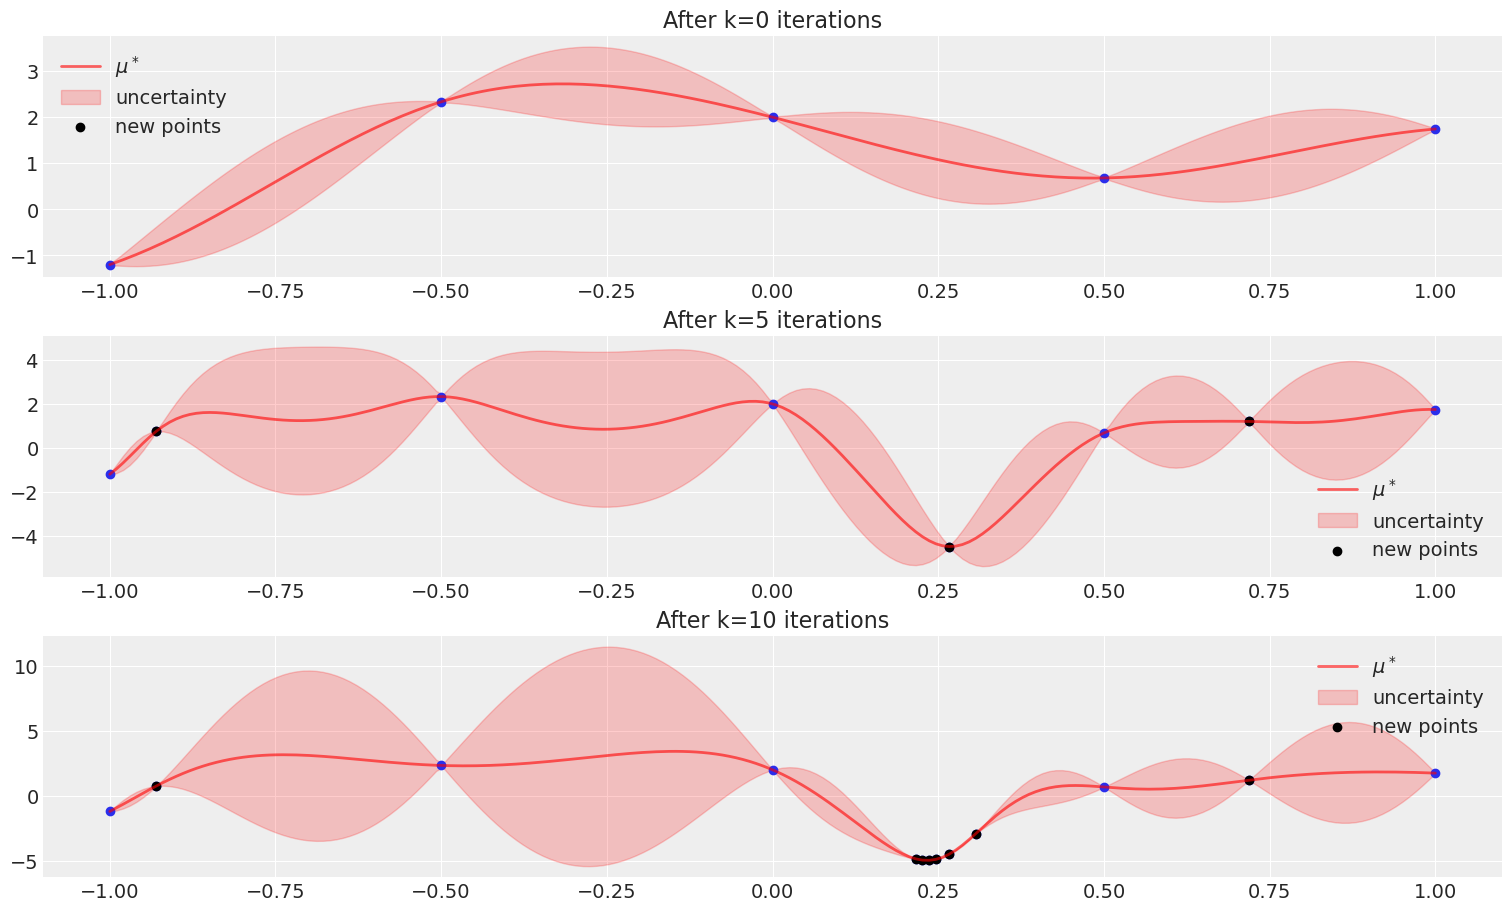

In [36]:
# torch.manual_seed(2000)
torch.manual_seed(2005)
T = 20
n_reps = 10 # Number of repetitions to repeat Baeysian optimization algorithm
ks = (0, 5, 10)
kappa = torch.tensor(1.)

def GP_LCB(X, y, X_star, y_star, T, naive=True, print=False):

    no_iter = 0 
    beta = torch.sqrt(kappa * torch.log((torch.arange(T) + 1)))
    if print == True:
        fig, axs = plt.subplots(3, 1, figsize=(15, 9))

    new_x_points = []
    new_y_points = []

    for k in range(T):

        pyro.clear_param_store()
        # kernel = gp.kernels.RBF(input_dim=1)
        # kernel = gp.kernels.Matern32(input_dim=1)
        kernel = gp.kernels.Matern52(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))
        nuts_kernel = NUTS(gpr.model)
        mcmc = MCMC(nuts_kernel, num_samples=1, disable_progbar=True, warmup_steps=10)
        try:
            mcmc.run()
        except: 
            mcmc.run()

        gpr.kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][0]
        gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][0]
        
        with torch.no_grad():
            mean, cov = gpr(X_star, full_cov=True, noiseless=False)

        if k in ks and print==True:
            sd = cov.diag().sqrt()  # standard deviation at each input point x
            axs[ks.index(k)].plot(X_star.numpy(), mean.numpy(), lw=2, c='r', alpha=0.6, label=f'$\mu^*$')  # plot the mean
            axs[ks.index(k)].set_title(f'After k={k} iterations')
            axs[ks.index(k)].fill_between(X_star,  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="r",
            alpha=0.2,
            label='uncertainty'
            )
            axs[ks.index(k)].scatter(X, y)
            axs[ks.index(k)].scatter(new_x_points, new_y_points, color='k', label='new points')
            axs[ks.index(k)].legend()

        # Use GP-LCB and update
        if naive == True:
            idx_p = (mean - beta[k] * cov.diag().sqrt()).argmin()
            x_p = X_star[idx_p]
            f_x_p = f(x_p)
        else:
            idxs = torch.argsort(mean - beta[k] * cov.diag().sqrt())
            for idx in idxs:
                x_p = X_star[idx]
                f_x_p = f(x_p)
                if f_x_p not in y:
                    break

        if f_x_p == min(y_star) and f_x_p not in y:
            no_iter = k # Number of iterations till minimum is found

        if f_x_p not in y:
            x_p_idx = torch.searchsorted(X, x_p)
            X = torch.from_numpy(np.insert(X.numpy(), x_p_idx.numpy(), x_p.numpy()))
            y = torch.from_numpy(np.insert(y.numpy(), x_p_idx.numpy(), f_x_p))
            new_x_points.append(x_p)
            new_y_points.append(f_x_p)

    return min(y), no_iter

min_y = GP_LCB(X, y, X_star, y_star, T, print=True)

min_ys = torch.zeros(n_reps)
no_iters = torch.zeros(n_reps)
for i in range(n_reps):
    min_ys[i], no_iters[i] = GP_LCB(X, y, X_star, y_star, T, naive=True, print=False)

print('Found minimums, 10 reps:', min_ys)
print('Number of iterations to find min:', no_iters)

C:\Users\Juliu\AppData\Local\Temp\ipykernel_15860\4139916549.py:8: RuntimeWarning: invalid value encountered in log
  pdf = (np.exp(-(np.log(xx) - mu)**2 / (2 * sigma**2))


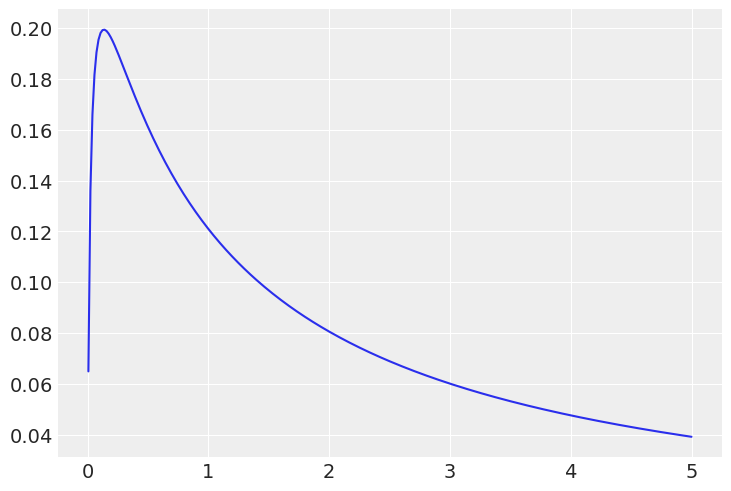

In [296]:
## For examining what better priors could look like

from scipy.stats import lognorm
mu = 2
sigma = 2
xx = np.linspace(-0.01,5,300)

pdf = (np.exp(-(np.log(xx) - mu)**2 / (2 * sigma**2))
       / (xx * sigma * np.sqrt(2 * np.pi)))

plt.plot(xx,pdf)